In [396]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import torchvision.models as models
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Downloading Dataset

In [397]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')


Using downloaded and verified file: ./cifar10.tgz


## Printing classes of datset

In [398]:
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)


['train', 'test']
['deer', 'truck', 'ship', 'horse', 'bird', 'airplane', 'frog', 'automobile', 'dog', 'cat']


## Normalising the datset

In [399]:
stats=((0.485,0.456,0.406),(0.229,0.224,0.225))
train_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats,inplace=True)])
valid_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [400]:
train_ds=ImageFolder(data_dir+'/train',train_tfms)
valid_ds=ImageFolder(data_dir+'/test',valid_tfms)

In [401]:
train_ds

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [402]:
batch_size=400

In [403]:
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
val_loader=DataLoader(valid_ds,batch_size*2,num_workers=3,pin_memory=2)

## Selecting GPU

In [404]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
    
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) 
        
    

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [405]:
device = get_default_device()
device

device(type='cuda')

In [406]:
train_dl=DeviceDataLoader(train_loader,device)
valid_dl=DeviceDataLoader(val_loader,device)

In [407]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#class Help(nn.Module):
def training_step( batch,model):
    images, labels = batch 
    out = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss
    
def validation_step( batch,model):
    images, labels = batch 
    out = model(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
        
def validation_epoch_end( outputs,model):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
def epoch_end( epoch, result,model):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Downloading Pretrained model

In [408]:
model=models.resnet18(pretrained=True)   
        
                            

In [409]:
model = to_device(model, device)


In [410]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(batch,model) for batch in val_loader]
    return validation_epoch_end(outputs,model)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(batch,model)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(epoch, result,model)
        history.append(result)
    return history

## Hyperparameters

In [411]:
epochs = 100
max_lr = 0.01
grad_clip = 0.1
weight_decay = 0.0001
opt_func = torch.optim.Adam

## Plotting for different Hyperparameters

max_lr: 0.01 -- grad_clip: 0.1 weight_decay: 0.0001
Epoch [0], last_lr: 0.00043, train_loss: 1.6315, val_loss: 0.7449, val_acc: 0.7407
Epoch [1], last_lr: 0.00050, train_loss: 0.5940, val_loss: 0.6031, val_acc: 0.7941
Epoch [2], last_lr: 0.00063, train_loss: 0.4160, val_loss: 0.6552, val_acc: 0.7874
Epoch [3], last_lr: 0.00081, train_loss: 0.3381, val_loss: 0.6458, val_acc: 0.7952
Epoch [4], last_lr: 0.00104, train_loss: 0.3158, val_loss: 0.6753, val_acc: 0.7870
Epoch [5], last_lr: 0.00131, train_loss: 0.2942, val_loss: 0.7245, val_acc: 0.7807
Epoch [6], last_lr: 0.00163, train_loss: 0.2909, val_loss: 0.7196, val_acc: 0.7845
Epoch [7], last_lr: 0.00199, train_loss: 0.2769, val_loss: 0.8340, val_acc: 0.7673
Epoch [8], last_lr: 0.00238, train_loss: 0.2847, val_loss: 0.7618, val_acc: 0.7744
Epoch [9], last_lr: 0.00280, train_loss: 0.2755, val_loss: 0.8272, val_acc: 0.7534
Epoch [10], last_lr: 0.00325, train_loss: 0.2733, val_loss: 0.8977, val_acc: 0.7438
Epoch [11], last_lr: 0.00371, trai

Epoch [98], last_lr: 0.00001, train_loss: 0.0003, val_loss: 1.0804, val_acc: 0.8071
Epoch [99], last_lr: 0.00000, train_loss: 0.0003, val_loss: 1.0815, val_acc: 0.8064


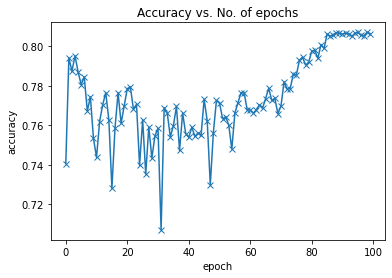

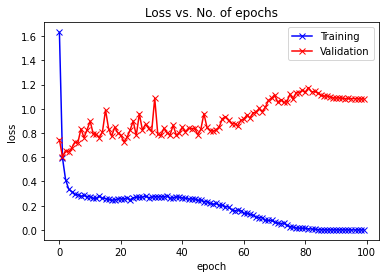

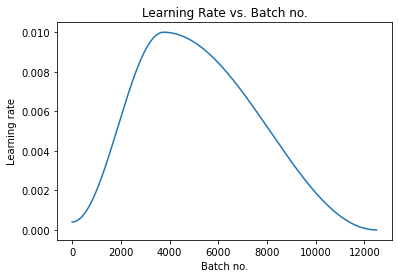

max_lr: 0.01 -- grad_clip: 0.1 weight_decay: 0.0006000000000000001
Epoch [0], last_lr: 0.00043, train_loss: 0.0028, val_loss: 1.0261, val_acc: 0.7937
Epoch [1], last_lr: 0.00050, train_loss: 0.0086, val_loss: 1.0327, val_acc: 0.7908
Epoch [2], last_lr: 0.00063, train_loss: 0.0147, val_loss: 1.0366, val_acc: 0.7846
Epoch [3], last_lr: 0.00081, train_loss: 0.0279, val_loss: 1.0702, val_acc: 0.7812
Epoch [4], last_lr: 0.00104, train_loss: 0.0518, val_loss: 1.0500, val_acc: 0.7735
Epoch [5], last_lr: 0.00131, train_loss: 0.0864, val_loss: 1.0186, val_acc: 0.7702
Epoch [6], last_lr: 0.00163, train_loss: 0.0901, val_loss: 1.0162, val_acc: 0.7707
Epoch [7], last_lr: 0.00199, train_loss: 0.1009, val_loss: 0.9418, val_acc: 0.7720
Epoch [8], last_lr: 0.00238, train_loss: 0.1477, val_loss: 1.0176, val_acc: 0.7582
Epoch [9], last_lr: 0.00280, train_loss: 0.1766, val_loss: 0.9485, val_acc: 0.7485
Epoch [10], last_lr: 0.00325, train_loss: 0.1802, val_loss: 0.9284, val_acc: 0.7537
Epoch [11], last_lr

Epoch [97], last_lr: 0.00002, train_loss: 0.0022, val_loss: 1.0439, val_acc: 0.7782
Epoch [98], last_lr: 0.00001, train_loss: 0.0023, val_loss: 1.0458, val_acc: 0.7786
Epoch [99], last_lr: 0.00000, train_loss: 0.0021, val_loss: 1.0464, val_acc: 0.7792


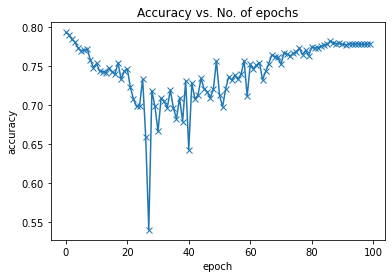

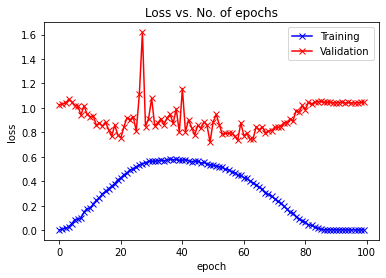

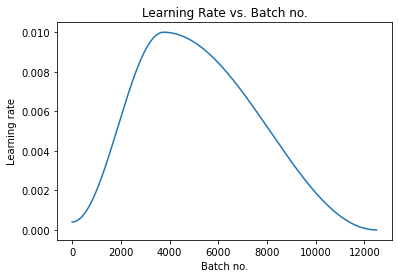

max_lr: 0.01 -- grad_clip: 0.6 weight_decay: 0.0001
Epoch [0], last_lr: 0.00043, train_loss: 0.0052, val_loss: 1.1311, val_acc: 0.7746
Epoch [1], last_lr: 0.00050, train_loss: 0.0084, val_loss: 1.1997, val_acc: 0.7701
Epoch [2], last_lr: 0.00063, train_loss: 0.0195, val_loss: 1.2482, val_acc: 0.7690
Epoch [3], last_lr: 0.00081, train_loss: 0.0360, val_loss: 1.3197, val_acc: 0.7619
Epoch [4], last_lr: 0.00104, train_loss: 0.0611, val_loss: 1.2511, val_acc: 0.7630
Epoch [5], last_lr: 0.00131, train_loss: 0.0958, val_loss: 1.1734, val_acc: 0.7616
Epoch [6], last_lr: 0.00163, train_loss: 0.0971, val_loss: 1.1998, val_acc: 0.7625
Epoch [7], last_lr: 0.00199, train_loss: 0.1090, val_loss: 1.1459, val_acc: 0.7606
Epoch [8], last_lr: 0.00238, train_loss: 0.1300, val_loss: 1.1048, val_acc: 0.7581
Epoch [9], last_lr: 0.00280, train_loss: 0.1360, val_loss: 1.1332, val_acc: 0.7522
Epoch [10], last_lr: 0.00325, train_loss: 0.1618, val_loss: 1.0946, val_acc: 0.7564
Epoch [11], last_lr: 0.00371, trai

Epoch [98], last_lr: 0.00001, train_loss: 0.0004, val_loss: 1.3815, val_acc: 0.7805
Epoch [99], last_lr: 0.00000, train_loss: 0.0004, val_loss: 1.3714, val_acc: 0.7811


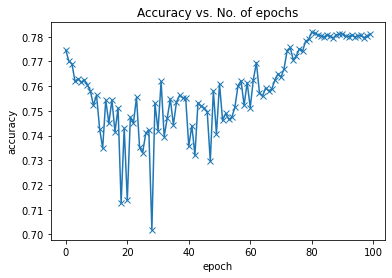

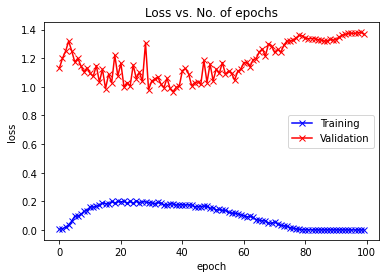

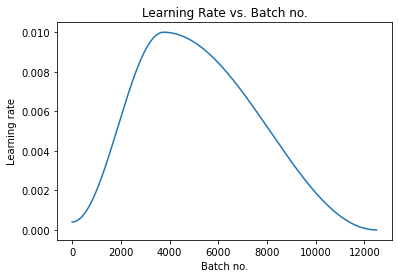

max_lr: 0.01 -- grad_clip: 0.6 weight_decay: 0.0006000000000000001
Epoch [0], last_lr: 0.00043, train_loss: 0.0020, val_loss: 1.2972, val_acc: 0.7755
Epoch [1], last_lr: 0.00050, train_loss: 0.0055, val_loss: 1.2592, val_acc: 0.7774
Epoch [2], last_lr: 0.00063, train_loss: 0.0078, val_loss: 1.2646, val_acc: 0.7698
Epoch [3], last_lr: 0.00081, train_loss: 0.0144, val_loss: 1.2569, val_acc: 0.7680
Epoch [4], last_lr: 0.00104, train_loss: 0.0369, val_loss: 1.2014, val_acc: 0.7648
Epoch [5], last_lr: 0.00131, train_loss: 0.0555, val_loss: 1.1881, val_acc: 0.7635
Epoch [6], last_lr: 0.00163, train_loss: 0.0691, val_loss: 1.2157, val_acc: 0.7563
Epoch [7], last_lr: 0.00199, train_loss: 0.0944, val_loss: 1.1200, val_acc: 0.7608
Epoch [8], last_lr: 0.00238, train_loss: 0.1200, val_loss: 1.1183, val_acc: 0.7535
Epoch [9], last_lr: 0.00280, train_loss: 0.1334, val_loss: 1.0725, val_acc: 0.7513
Epoch [10], last_lr: 0.00325, train_loss: 0.1602, val_loss: 1.1086, val_acc: 0.7406
Epoch [11], last_lr

Epoch [97], last_lr: 0.00002, train_loss: 0.0023, val_loss: 1.0963, val_acc: 0.7755
Epoch [98], last_lr: 0.00001, train_loss: 0.0022, val_loss: 1.0907, val_acc: 0.7765
Epoch [99], last_lr: 0.00000, train_loss: 0.0022, val_loss: 1.0940, val_acc: 0.7755


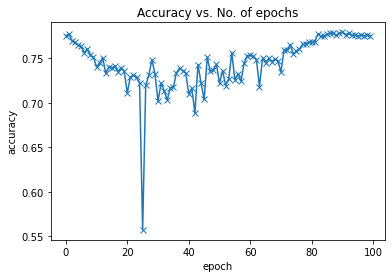

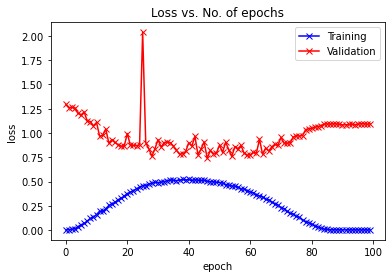

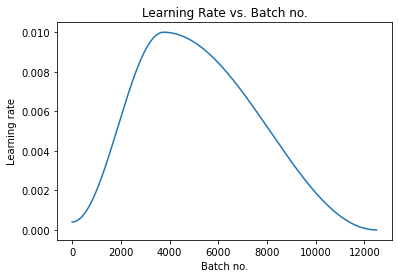

max_lr: 0.060000000000000005 -- grad_clip: 0.1 weight_decay: 0.0001
Epoch [0], last_lr: 0.00256, train_loss: 0.1803, val_loss: 1.0548, val_acc: 0.7575
Epoch [1], last_lr: 0.00302, train_loss: 0.1438, val_loss: 1.0127, val_acc: 0.7657
Epoch [2], last_lr: 0.00380, train_loss: 0.1725, val_loss: 1.0676, val_acc: 0.7463
Epoch [3], last_lr: 0.00488, train_loss: 0.2290, val_loss: 1.0150, val_acc: 0.7492
Epoch [4], last_lr: 0.00625, train_loss: 0.2519, val_loss: 1.0703, val_acc: 0.7210
Epoch [5], last_lr: 0.00789, train_loss: 0.2834, val_loss: 1.0052, val_acc: 0.7387
Epoch [6], last_lr: 0.00979, train_loss: 0.3063, val_loss: 0.9569, val_acc: 0.7309
Epoch [7], last_lr: 0.01192, train_loss: 0.3297, val_loss: 0.9450, val_acc: 0.7261
Epoch [8], last_lr: 0.01426, train_loss: 0.3536, val_loss: 0.8730, val_acc: 0.7398
Epoch [9], last_lr: 0.01679, train_loss: 0.3547, val_loss: 0.8913, val_acc: 0.7442
Epoch [10], last_lr: 0.01947, train_loss: 0.3775, val_loss: 0.9788, val_acc: 0.7074
Epoch [11], last_l

Epoch [97], last_lr: 0.00012, train_loss: 0.0118, val_loss: 1.2253, val_acc: 0.7645
Epoch [98], last_lr: 0.00003, train_loss: 0.0113, val_loss: 1.2252, val_acc: 0.7645
Epoch [99], last_lr: 0.00000, train_loss: 0.0112, val_loss: 1.2372, val_acc: 0.7633


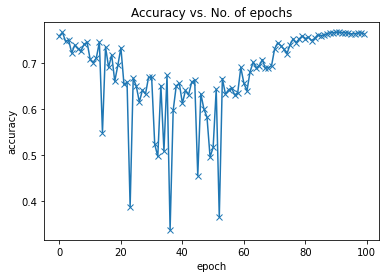

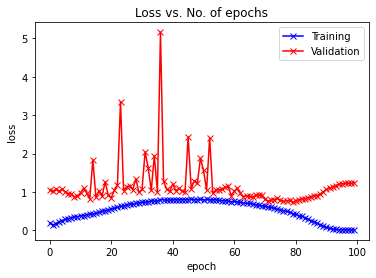

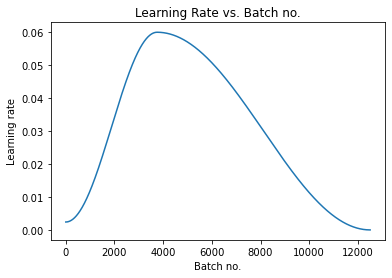

max_lr: 0.060000000000000005 -- grad_clip: 0.1 weight_decay: 0.0006000000000000001
Epoch [0], last_lr: 0.00256, train_loss: 0.0536, val_loss: 1.2870, val_acc: 0.7539
Epoch [1], last_lr: 0.00302, train_loss: 0.0824, val_loss: 1.2931, val_acc: 0.7480
Epoch [2], last_lr: 0.00380, train_loss: 0.1363, val_loss: 1.1747, val_acc: 0.7492
Epoch [3], last_lr: 0.00488, train_loss: 0.2066, val_loss: 1.0912, val_acc: 0.7466
Epoch [4], last_lr: 0.00625, train_loss: 0.2561, val_loss: 0.9941, val_acc: 0.7403
Epoch [5], last_lr: 0.00789, train_loss: 0.3113, val_loss: 0.9351, val_acc: 0.7322
Epoch [6], last_lr: 0.00979, train_loss: 0.3890, val_loss: 0.8238, val_acc: 0.7415
Epoch [7], last_lr: 0.01192, train_loss: 0.4523, val_loss: 0.8578, val_acc: 0.7251
Epoch [8], last_lr: 0.01426, train_loss: 0.5127, val_loss: 1.2708, val_acc: 0.6228
Epoch [9], last_lr: 0.01679, train_loss: 0.5726, val_loss: 0.8652, val_acc: 0.7131
Epoch [10], last_lr: 0.01947, train_loss: 0.6308, val_loss: 1.1883, val_acc: 0.6404
Epo

Epoch [97], last_lr: 0.00012, train_loss: 0.5550, val_loss: 0.8147, val_acc: 0.7314
Epoch [98], last_lr: 0.00003, train_loss: 0.5462, val_loss: 0.8163, val_acc: 0.7307
Epoch [99], last_lr: 0.00000, train_loss: 0.5424, val_loss: 0.8156, val_acc: 0.7300


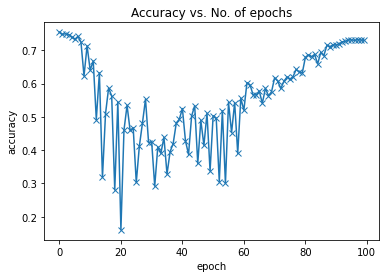

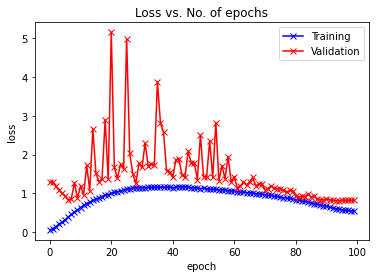

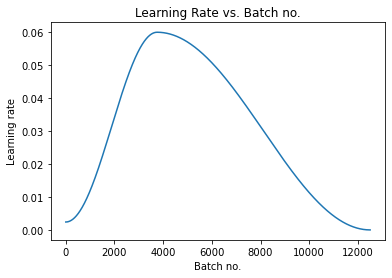

max_lr: 0.060000000000000005 -- grad_clip: 0.6 weight_decay: 0.0001
Epoch [0], last_lr: 0.00256, train_loss: 0.6258, val_loss: 0.8431, val_acc: 0.7212
Epoch [1], last_lr: 0.00302, train_loss: 0.6142, val_loss: 0.9113, val_acc: 0.6998
Epoch [2], last_lr: 0.00380, train_loss: 0.6296, val_loss: 0.8489, val_acc: 0.7180
Epoch [3], last_lr: 0.00488, train_loss: 0.6472, val_loss: 0.9114, val_acc: 0.6938
Epoch [4], last_lr: 0.00625, train_loss: 0.6543, val_loss: 0.9277, val_acc: 0.6883
Epoch [5], last_lr: 0.00789, train_loss: 0.6782, val_loss: 1.1088, val_acc: 0.6429
Epoch [6], last_lr: 0.00979, train_loss: 0.7029, val_loss: 1.0295, val_acc: 0.6607
Epoch [7], last_lr: 0.01192, train_loss: 0.7219, val_loss: 1.0448, val_acc: 0.6605
Epoch [8], last_lr: 0.01426, train_loss: 0.7370, val_loss: 0.9437, val_acc: 0.6711
Epoch [9], last_lr: 0.01679, train_loss: 0.7455, val_loss: 0.9773, val_acc: 0.6736
Epoch [10], last_lr: 0.01947, train_loss: 0.7505, val_loss: 1.0353, val_acc: 0.6493
Epoch [11], last_l

Epoch [97], last_lr: 0.00012, train_loss: 0.4677, val_loss: 0.8777, val_acc: 0.7261
Epoch [98], last_lr: 0.00003, train_loss: 0.4647, val_loss: 0.8764, val_acc: 0.7268
Epoch [99], last_lr: 0.00000, train_loss: 0.4639, val_loss: 0.8807, val_acc: 0.7282


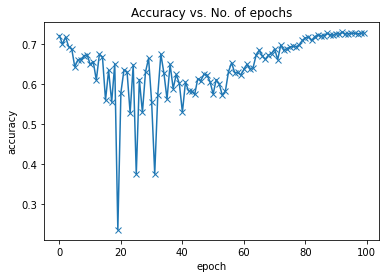

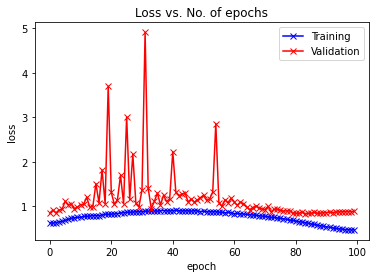

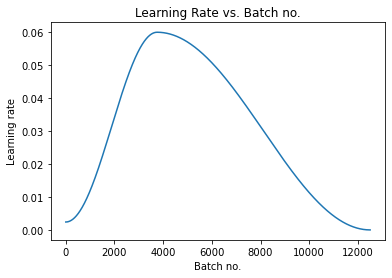

max_lr: 0.060000000000000005 -- grad_clip: 0.6 weight_decay: 0.0006000000000000001
Epoch [0], last_lr: 0.00256, train_loss: 0.5156, val_loss: 0.8677, val_acc: 0.7250
Epoch [1], last_lr: 0.00302, train_loss: 0.5066, val_loss: 0.8768, val_acc: 0.7270
Epoch [2], last_lr: 0.00380, train_loss: 0.5207, val_loss: 0.9082, val_acc: 0.7153
Epoch [3], last_lr: 0.00488, train_loss: 0.5429, val_loss: 0.8693, val_acc: 0.7174
Epoch [4], last_lr: 0.00625, train_loss: 0.5655, val_loss: 0.8930, val_acc: 0.7075
Epoch [5], last_lr: 0.00789, train_loss: 0.6022, val_loss: 0.8651, val_acc: 0.7117
Epoch [6], last_lr: 0.00979, train_loss: 0.6431, val_loss: 0.9310, val_acc: 0.6855
Epoch [7], last_lr: 0.01192, train_loss: 0.6806, val_loss: 0.9383, val_acc: 0.6826
Epoch [8], last_lr: 0.01426, train_loss: 0.7297, val_loss: 0.9425, val_acc: 0.6761
Epoch [9], last_lr: 0.01679, train_loss: 0.7591, val_loss: 1.0453, val_acc: 0.6542
Epoch [10], last_lr: 0.01947, train_loss: 0.7917, val_loss: 1.0796, val_acc: 0.6402
Epo

Epoch [97], last_lr: 0.00012, train_loss: 0.5646, val_loss: 0.8349, val_acc: 0.7197
Epoch [98], last_lr: 0.00003, train_loss: 0.5598, val_loss: 0.8359, val_acc: 0.7200
Epoch [99], last_lr: 0.00000, train_loss: 0.5559, val_loss: 0.8336, val_acc: 0.7212


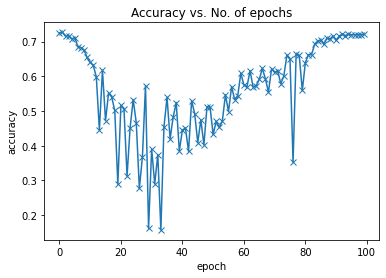

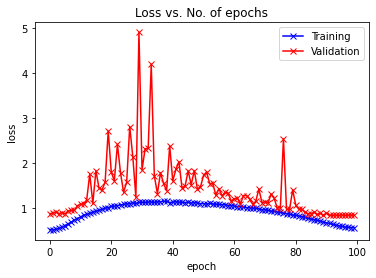

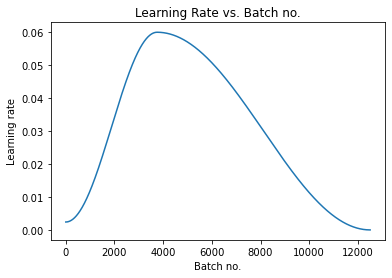

In [412]:

while max_lr<=0.1:
    grad_clip = 0.1
    while grad_clip <=1:
        weight_decay = 0.0001
        while weight_decay <= 0.001:
            print("max_lr:",max_lr,"--","grad_clip:",grad_clip,"weight_decay:",weight_decay)
            history=[]
            history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                                         grad_clip=grad_clip, 
                                         weight_decay=weight_decay, 
                                        opt_func=opt_func)
          
            accuracies = [x['val_acc'] for x in history]
            plt.plot(accuracies, '-x')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.title('Accuracy vs. No. of epochs');
            
            
            
            plt.show()
            
            train_losses = [x.get('train_loss') for x in history]
            val_losses = [x['val_loss'] for x in history]
            plt.plot(train_losses, '-bx')
            plt.plot(val_losses, '-rx')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend(['Training', 'Validation'])
            plt.title('Loss vs. No. of epochs');
            plt.show()
            
            lrs = np.concatenate([x.get('lrs', []) for x in history])
            plt.plot(lrs)
            plt.xlabel('Batch no.')
            plt.ylabel('Learning rate')
            plt.title('Learning Rate vs. Batch no.');
            
            plt.show()
            
            
            weight_decay=weight_decay+0.0005
            
        grad_clip=grad_clip+0.5
    max_lr=max_lr+0.05

## Testing Model

In [413]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


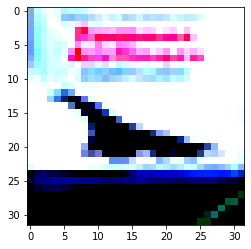

In [414]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: truck


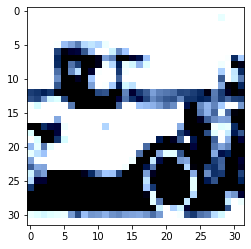

In [415]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog , Predicted: frog


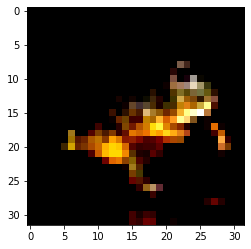

In [416]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))